In [1]:
%matplotlib inline

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import patsy as pat
import nibabel as nib
import seaborn as sbn
import pathlib as pal
from scipy import io as sio
from matplotlib import pyplot as plt
from sklearn import linear_model as sln
from sklearn import model_selection as skm

In [3]:
def octvec2mat(vec, mask):
    """
    Takes a vector in Fortran style (Octave/Matlab)
    and maps it back into a mask correctly in 
    python
    """
    vec_mat = mask.flatten(order='F').astype(bool)
    tmp = np.zeros_like(vec_mat, dtype=float)
    tmp[vec_mat] = vec
    vol = np.reshape(tmp, mask.shape, order='F')
    return vol

In [4]:
def vec2mat(vec, mask):
    tmp_mat = octvec2mat(vec, mask)
    tmp_mat += tmp_mat.T
    tmp_mat[np.eye(mask.shape[0]).astype(bool)] = tmp_mat[np.eye(mask.shape[0]).astype(bool)]/2
    return tmp_mat

In [5]:
root_p = pal.Path('/home/surchs/data/')
data_p = root_p / 'GSP_all/glm/main_effect_BVnoTIV_50_withFD/cambridge64/individual'
conn_t = 'connectome_{}_cambridge64.mat'
pheno_p = root_p / 'GSP_all/pheno/DataRelease_2014_underscore_FD.csv'

labels_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
labels7_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
labels12_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
hier_p = root_p / 'ATLAS/MIST/Hierarchy/MIST_PARCEL_ORDER.csv'
temp_p = root_p / 'ATLAS/MIST/Parcellations/MIST_64.nii.gz'

fig_p = root_p /  'paper_16p22q/figures/unclear/'

In [6]:
pheno = pd.read_csv(pheno_p)
pheno.rename(columns={'Unnamed: 0':'niak_id'}, inplace=True)

In [7]:
temp_i = nib.load(str(temp_p))
temp = temp_i.get_data()

## Steps to take:

1. Load the connectome of everyone
2. k-fold generator. split 2 pairs of groups
3. compute group difference across 2080 connections. Raw values, no FDR. Control for nuisance (age, sex, motion)
4. Keep the betas for each group contrast
5. Correlate the betas between the two contrasts, keep the 64 correlation scores
6. Show them

## Load connectomes

In [8]:
connectome_paths = list()
connectome_ids = list()

for rid, row in pheno.iterrows():
    connectome_p = data_p / conn_t.format(row['niak_id']) 
    if connectome_p.is_file():
        connectome_paths.append(connectome_p)
        connectome_ids.append(rid)

In [9]:
columns = ['niak_id', 'Age_Bin', 'age_norm', 'sex_dummy', 'FD_scrubbed_s1_s2', 'FD_scrubbed_s1_s2_norm']
pheno_data = pheno.loc[connectome_ids, columns]
pheno_data.reset_index(inplace=True)
n_subjects = pheno_data.shape[0]

In [10]:
conn = np.zeros((n_subjects, 2080))

start = time.time()
for conn_id, conn_p in enumerate(connectome_paths):
    conn[conn_id, :] = sio.loadmat(conn_p)['mean_fd']['connectome'][0][0]
    
    elapsed = time.time() - start
    done = conn_id+1
    remaining = n_subjects - done
    time_left = (elapsed/done)*remaining
    sys.stdout.write('\r {}/{}. {:.2f}s left'.format(done, n_subjects, time_left))
    sys.stdout.flush()
sys.stdout.write('\r Done. Took {:.2f}s'.format(elapsed))
sys.stdout.flush()

 Done. Took 48.54s

In [11]:
n_iter = 5000

## Repeatedly compute the betas for the random groups

In [12]:
shsp = skm.ShuffleSplit(n_splits=n_iter, test_size=0.5)
half_point = np.floor(n_subjects/2).astype(int)
group = np.zeros(n_subjects)
pheno_data['group'] = 0
glm = sln.LinearRegression(fit_intercept=True, n_jobs=-2)

beta = np.zeros((2080, 2, n_iter))
start = time.time()
for fold_id, (control, patient) in enumerate(shsp.split(np.ones(n_subjects))):
    group[control] = 0
    group[patient] = 1
    pheno_data['group'] = group
    
    mat1 = pat.dmatrix('sex_dummy + Age_Bin + FD_scrubbed_s1_s2 + group', pheno_data[:half_point])
    mat2 = pat.dmatrix('sex_dummy + Age_Bin + FD_scrubbed_s1_s2 + group', pheno_data[half_point:])
    res1 = glm.fit(mat1, conn[:half_point, :])
    beta[:, 0, fold_id] = res1.coef_[:, -1]
    res2 = glm.fit(mat2, conn[half_point:, :])
    beta[:, 1, fold_id] = res2.coef_[:, -1]
    
    elapsed = time.time() - start
    done = fold_id+1
    remaining = n_iter - done
    time_left = (elapsed/done)*remaining
    sys.stdout.write('\r {}/{}. {:.2f}s left ({:.3f}s)'.format(done, n_iter, time_left, elapsed/done))
    sys.stdout.flush()
sys.stdout.write('\r Done. Took {:.2f}s'.format(elapsed))
sys.stdout.flush()

 Done. Took 727.73s

## Compute the correlation between the betas

In [13]:
mask = np.tril(np.ones((64,64))).astype(bool)
corr = np.zeros((64, n_iter))
for fold_id in range(n_iter):
    # Map the betas back to a matrix
    beta1_mat = vec2mat(beta[:, 0, fold_id], mask)
    beta2_mat = vec2mat(beta[:, 1, fold_id], mask)
    # Compute the correlation
    corr[:, fold_id] =  np.array([np.corrcoef(beta1_mat[nid, :], beta2_mat[nid, :])[0,1] for nid in range(64)])

In [14]:
upper = np.percentile(corr, 95, axis=1)
mean = np.mean(corr, 1)
lower = np.percentile(corr, 5, axis=1)

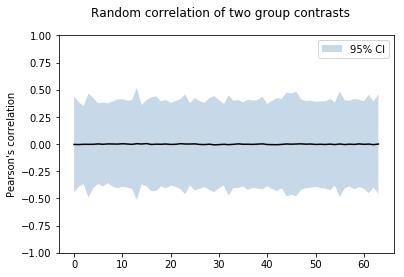

In [15]:
plt.fill_between(np.arange(64), lower, upper, facecolor='steelblue', alpha=0.3, interpolate=False, label='95% CI')
plt.plot(np.arange(64), mean, 'k')
plt.ylim([-1, 1]);
plt.legend()
plt.ylabel('Pearson\'s correlation');
plt.suptitle('Random correlation of two group contrasts');

This looks pretty reasonable. We can't really treat these tests as fully independent but at least:
- there is no region bias
- the 95% confidence interval only includes +/- 0.4

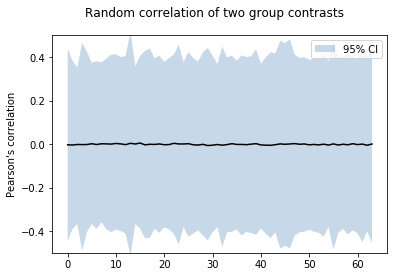

In [16]:
plt.fill_between(np.arange(64), lower, upper, facecolor='steelblue', alpha=0.3, interpolate=False, label='95% CI')
plt.plot(np.arange(64), mean, 'k')
plt.ylim([-0.5, 0.5]);
plt.legend()
plt.ylabel('Pearson\'s correlation');
plt.suptitle('Random correlation of two group contrasts');

In [17]:
np.mean(upper)

0.4112851644568323

In [18]:
np.mean(lower)

-0.414319401717504

In [19]:
np.mean(mean)

-0.001265975416128022